# Hamiltonian Simulation

Quantum Hamiltonian simulation is one of the most important problems in quantum computing. It consists of modeling the time evolution of a complex quantum system using more controllable devices; the quantum computers. Simulations of this type are essential to comprehend quantum systems that are described by complex dynamics, such as molecules in chemistry or materials in condensed matter physics, where classical computers fail due to the exponential scale up required by larger quantum systems.

In this guide, you will be using Classiq to work with simple problems of Hamiltonian simulation using two different methods:

* **Suzuki-Trotter decomposition**
* **qDRIFT**

Apart from these methods, known as **product formulas**, this guide also briefly discusses block-encoding methods and links to a specific guide on this topic.

# Table of contents

1. [Intoduction](#Intoduction)
3. [Suzuki-Trotter decomposition](#Suzuki-Trotter-decomposition)
    * [Exponentiation with depth constraint](#exponentiation-with-depth-constraint)
4. [qDRIFT](#qDRIFT)
5. [Hamiltonian simulation with block encoding](#Hamiltonian-simulation-with-block-encoding)
6. [Measuring the expected magnetization as a function of time](#measuring-the-expected-magnetization-as-a-function-of-time)
7. [Summary and Exercises](#summary-and-exercises)


# Intoduction

Quantum Hamiltonian simulation has several significant applications. Some of them are directly related to physics and chemistry, while others extend to fields such as optimization and machine learning:

* Quantum Chemistry: It helps predict the properties of molecules using quantum methods such as the Quantum Variational Eigensolver (VQE), which can be more efficient than classical methods in certain conditions.
* Materials Science: It aids in designing new materials with desired properties by simulating their quantum mechanical behavior.
* Optimization and Machine Learning: The use of quantum Hamiltonian simulation algorithms in optimization and machine learning is an active area of research. These algorithms are often incorporated as subroutines within broader quantum algorithms, combined with other quantum techniques tailored to optimization and machine learning tasks.

Within the framework of **product formulas**, we can mathematically approach the Hamiltonian Simulation problem as follows: Suppose we have a quantum computer that can run the evolution operators of the set of Hamiltonians $\{H_j\}$ natively. Now, suppose you want to understand the dynamics of the following, more complex, Hamiltonian:

<details><summary>What are the operations that this quantum computer can effectively execute?</summary>

If this quantum computer can only execute the evolution operators of the set of Hamiltonians $\{H_j\}$, then you could only have operations in the form:

$$O = \prod_{j} e^{-i \,\tau_j H_j}.$$
</details>

\begin{equation}
H_{full} = \sum_{j} h_j H_j,
\end{equation}

For some real values $h_j$. Therefore, a decomposition of the operator into the set of operations is needed, formed by $\{e^{-itH_j}\}$, where $e^{-itH_j}$ is the evolution operator of the Hamiltonian $H$.

## Suzuki-Trotter Decomposition

Now that the problem is stated, a possible solution is the Suzuki-Trotter decomposition, also known as Trotterization. Simply put, this method involves 'breaking' the evolution operator into the evolution operators of its components. In the **first order**, it looks like this:

\begin{equation*}
e^{-itH}=\exp\left\{-it\sum_{j=1}^N h_j H_j\right\} \approx \left(\prod_{j}^N e^{-it h_j H_j/r}\right)^r + \mathcal{O}(t^2/r).
\end{equation*}

Details about this decomposition are in [[1]](#ts_paper).

This formula is important and has applications in several scenarios. Additionally, if you need an error that scales better than $t^2$, it is possible to achieve higher-order Suzuki-Trotter formulas. For example, the **second-order** Suzuki-Trotter would look like this:

\begin{equation*}
e^{-itH}=\exp\left\{-i\left(\sum_{j=1}^N \frac{t_j}{2}\,H_j + \sum_{j=N}^1 \frac{t_j}{2}\,H_j\right)\right\} \approx \left(\prod_{j=1}^N e^{-it_j\, H_j/(2r)}\prod_{j=N}^1 e^{-it_j\, H_j/(2r)}\right)^r + \mathcal{O}(t^3/r).
\end{equation*}


Higher orders for the Suzuki-Trotter formula are in [[1](#ts_paper)]. However, as the number of terms in the Hamiltonian and the approximation order increases, it gets more complicated to construct the Suzuki-Trotter formulas. To this end, use the Classiq `suzuki_trotter()` function to execute an operator's Trotter decomposition, specifying the order and number of repetitions.

The function's inputs are:

* `pauli_operator`: `CArray[PauliTerm]`: The Pauli operator to be exponentiated, representing the term \( H_j \) and its respective coefficients \( h_j \);
* `evolution_coefficient`: `CArray`: A global evolution coefficient multiplying the Pauli operator, representing the value \( t \) for the coefficient in the time evolution operator;
* `order`: `CInt`: The order of the Suzuki-Trotter decomposition;
* `repetitions`: `CInt`: The number of repetitions of the Suzuki-Trotter decomposition;
* `qbv`: `QArray[QBit]`: The target quantum variable of the exponentiation, representing the qubits on which the operation will be applied.

The following example demonstrates how to use it:

Now that the inputs for the Suzuki-Trotter method are defined, apply it to the example of approximating the dynamics of the following two-qubits Hamiltonian: 


$$H = 0.3 \, Z\otimes Z + 0.7 \,X\otimes I + 0.2\, I\otimes X,$$

which represents two spins interacting in a transversal field. Identify the operators $\{H_j\}$ and their respective coefficients $\{h_j\}$:

$$
\begin{split}
    H_1 = Z \otimes Z,\text{ coefficient: }h_1 = 0.3; \\
    H_2 = X \otimes I,\text{ coefficient: }h_2 = 0.7; \\
    H_3 = I \otimes X,\text{ coefficient: }h_3 = 0.2. \\
\end{split}
$$

Define the number of  $r$ repetitions into which to "break" the evolution, in this case,  $r=10$. The order of the Suzuki-Trotter decomposition can be altered in the parameter ``order``. In the current case, apply it to the first order. 

Define the evolution coefficient $t$, stating how much time the quantum system will be evolving under this Hamiltonian, according to the specific application you want. Set the evolution coefficient in the `evolution_coefficient` variable, considering it unitary in this example. In [this part of the guide](#measuring-the-expected-magnetization-as-a-function-of-time), you can follow an example where the evolution coefficient varies.

In [1]:
from classiq import *

# Defining the Hamiltonian:
HAMILTONIAN = [
    PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=0.3),
    PauliTerm(pauli=[Pauli.X, Pauli.I], coefficient=0.7),
    PauliTerm(pauli=[Pauli.I, Pauli.X], coefficient=0.2),
]


@qfunc
def main(qba: Output[QArray[QBit]]):
    allocate(2, qba)
    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=1.0,
        order=1,
        repetitions=10,
        qbv=qba,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
write_qmod(qmod, "trotter")
show(qprog)

Opening: https://platform.classiq.io/circuit/36940d25-3d68-4787-83fd-e5b554daa0a8?version=0.46.1


## Exponentiation with Depth Constraint

It is also possible to generate an efficient decomposition of an evolution operator with the Classiq `exponentiation_with_depth_constraint` function. Given the maximum depth of the decomposition and the inputs related to the Hamiltonian, the synthesizer finds and applies the most accurate higher-order Trotter decomposition. Its inputs are the same as in `suzuki_trotter`, except that `max_depth` replaces explicitly specifying the number of `repetitions`.

A maximum depth of 30 for the previous example yields:

In [2]:
from classiq import *


@qfunc
def main(qba: Output[QArray[QBit]]):

    allocate(2, qba)
    exponentiation_with_depth_constraint(
        HAMILTONIAN,
        evolution_coefficient=1,
        max_depth=30,
        qbv=qba,
    )


qmod = create_model(main)
write_qmod(qmod, "exponentiation")
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/5d67a7ca-c3bf-4629-b15c-763799c61379?version=0.46.1


The number of repetitions can also be understood from the IDE, it is the number of repetitive blocks you see. In the current case, it applies the first-order decomposition, denoted in the IDE by the name ``single_trotter_suzuki_layer_xxxx``. In the case of higher orders, the output would identify which order is being used.

![Trotter_gif](https://docs.classiq.io/resources/Trotter_order.gif)



## qDRIFT

The quantum stochastic drift protocol (qDRIFT) [[2]](#qdrift_paper) is similar to the first-order Suzuki-Trotter decomposition; however, it relies on a stochastic distribution of the evolution operators. The algorithm operates by sampling unitaries from the set $\{e^{-itH_j}\}$ according to a probability distribution defined by the weights $\{h_j\}$, normalized by a factor $\lambda = \sum_j h_j$. 

In a more structured manner, the qDRIFT protocol functions as follows:

**Input**: A list of Hamiltonian terms $\{H_j\}$, a classical oracle function SAMPLE() that returns a value $j$ according to the probability distribution $p_j = h_j/\lambda$, and a target precision $\epsilon$.

**Output**: An ordered list of evolution operators from the set $\{e^{-itH_j}\}$ that approximates the unitary $e^{-it\,H}$ with a bound error $\epsilon$.

* Define a normalization to transform $\{h_j\}$ into a probability distribution. For this, define $\sum_j h_j = \lambda$.
* The program depth is defined according to the required precision. For this, set $N = \lceil 2\lambda^2t^2/\epsilon \rceil$.
* Now generate the ordered list of $N$ evolution operators according to the probability distribution.

**The qDRIFT has proved to be a good alternative for the Suzuki-Trotter decomposition when the number of terms in the Hamiltonian is not Pauli sparse**, i.e., the number of terms on the expansion $H = \sum_j h_j H_j$ is not small when compared to all possible terms in it. This interesting method can be applied using the Classiq ``qdrift()`` function. 

Its inputs are:

* ``pauli_operator``: ``CArray[PauliTerm]``: A list of Pauli operators that represent the term $H_j$ and its respective coefficients $h_j$;
* ``evolution_coefficient ``: ``CArray`` The value $t$ for the coefficient in the time evolution operator;
* ``num_qdrift``:``CInt``: The number $N$ of unitary operators in the list of gates given by the qDRIFT;
* ``qbv``:``QArray[QBit]``: The target qubits.

In the current example, fix $N=288$, which corresponds to error $\epsilon = 0.01$ in the approximation.

In [3]:
from classiq import *


@qfunc
def main(qba: Output[QArray[QBit]]):

    allocate(2, qba)
    qdrift(
        HAMILTONIAN,
        evolution_coefficient=1,
        num_qdrift=288,
        qbv=qba,
    )


qmod = create_model(main)
write_qmod(qmod, "qdrift")
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/6c51d1df-91b2-488e-8f79-292d09396785?version=0.46.1


# Hamiltonian Simulation with Block Encoding

Other methods of Hamiltonian simulation outside of the **product formulas** leverage the idea of Block Encoding and eigenvalue transformations. These approaches allow for the efficient simulation of quantum systems by encoding operators into unitary matrices and applying transformations to the eigenvalues of these matrices.

## Qubitization

The qubitization [[3]](#qubitization_paper) method enables the efficient simulation of quantum Hamiltonians. The key idea is to embed the Hamiltonian into a larger unitary operator, a method known as block encoding, where the block-encoded Hamiltonian is simulated using a quantum walk operator. This allows precise control over the evolution of quantum states and can significantly reduce the resources required for Hamiltonian simulation. For details on implementing the Qubitization method, visit the [Hamiltonian simulation with block encoding](https://docs.classiq.io/latest/explore/tutorials/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding/) guide.

## QSVT

The general Quantum Singular Value Transformation (QSVT) [[4]](#qsvt_paper) method transforms the singular values of matrices encoded in quantum states. In Hamiltonian simulation, the objective is to use a sequence of quantum circuits to apply polynomial transformations to the singular values of a matrix, which are related to its eigenvalues. For details on how to implement the Qubitization method, visit the [Hamiltonian simulation with block encoding](https://docs.classiq.io/latest/explore/tutorials/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding/) guide.

# Measuring the Expected Magnetization as a Function of Time

Learn how to apply these different methods and evaluate their performance in comparison with the exact evolution. You will see the evolution of the expected value of a specific operator and compare it to the exact solution. This section uses the same Hamiltonian from the examples:

$$H = 0.3 \cdot \, Z\otimes Z + 0.7 \cdot \,X\otimes I + 0.2 \cdot \, I\otimes X$$

Now, analyze a quantity that varies with different values of time. For this, consider the behavior of the magnetization of the system, $M = (\langle I\otimes Z \rangle + \langle Z \otimes I\rangle)/2$ [[5]](#magnetization_paper), as a function of time. 

Precisely evaluate the result by exponentiating the Hamiltonian $H$ directly, and then comparing the results:

In [13]:
import numpy as np
from scipy.linalg import expm

time_list = np.linspace(0, 2, 100).tolist()

magnetization_hamiltonian = [
    PauliTerm(pauli=[Pauli.Z, Pauli.I], coefficient=0.5),
    PauliTerm(pauli=[Pauli.I, Pauli.Z], coefficient=0.5),
]

# Hamiltonians to matrices:
magnetization_matrix = hamiltonian_to_matrix(magnetization_hamiltonian)  # TODO
Hamiltonian_matrix = hamiltonian_to_matrix(HAMILTONIAN)  # TODO

initial_state = np.zeros(4)
initial_state[0] = 1.0


def expected_value(state, operator):
    state_H = np.conj(state.T)
    return state_H @ operator @ state


ideal_magnetization = []
for t in time_list:
    state = expm(-1j * t * Hamiltonian_matrix) @ initial_state
    ideal_magnetization.append(expected_value(state, magnetization_matrix))

To evaluate the expectation values of magnetization, use the ``estimate`` function for the Suzuki-Trotter and qDRIFT methods:

In [14]:
from classiq import *
from classiq.execution import ExecutionSession

# magnetization_hamiltonian = [
#     PauliTerm(pauli=[Pauli.Z, Pauli.I], coefficient=0.5),
#     PauliTerm(pauli=[Pauli.I, Pauli.Z], coefficient=0.5),
# ]


@qfunc
def main(t: CReal, qba: Output[QArray[QBit]]):
    allocate(2, qba)
    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=t,
        order=1,
        repetitions=30,
        qbv=qba,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
TS_execution = ExecutionSession(qprog)

magnetization_ST = []
for t_values in time_list:
    res = TS_execution.estimate(magnetization_hamiltonian, {"t": t_values}).value
    magnetization_ST.append(res)

In [15]:
magnetization_qdrift = []


@qfunc
def main(t: CReal, qba: Output[QArray[QBit]]):
    allocate(2, qba)
    qdrift(
        HAMILTONIAN,
        evolution_coefficient=t,
        num_qdrift=288,
        qbv=qba,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
qdrift_execution = ExecutionSession(qprog)
for t_values in time_list:
    res = qdrift_execution.estimate(magnetization_hamiltonian, {"t": t_values}).value
    magnetization_qdrift.append(res)

For ``exponentiation_with_depth_constraint``, values of ``evolution_coefficient`` must be defined before synthesizing, since it is an important part of finding the most efficient decomposition. Therefore, a loop is necessary to synthesize and execute the quantum program for different evolution coefficients, and the populations of the final states can be used to evaluate the expected magnetization: 

In [16]:
from classiq import *

magnetization_ewdc = []

for t in time_list:

    @qfunc
    def main(qba: Output[QArray[QBit]]):
        allocate(2, qba)
        exponentiation_with_depth_constraint(
            HAMILTONIAN,
            evolution_coefficient=t,
            max_depth=30,
            qbv=qba,
        )

    qmod = create_model(main)
    qprog = synthesize(qmod)
    ewdc_execution = ExecutionSession(qprog)
    res = ewdc_execution.estimate(magnetization_hamiltonian).value
    magnetization_ewdc.append(res)

You can plot the magnetization values of the three different methods with the exact values:

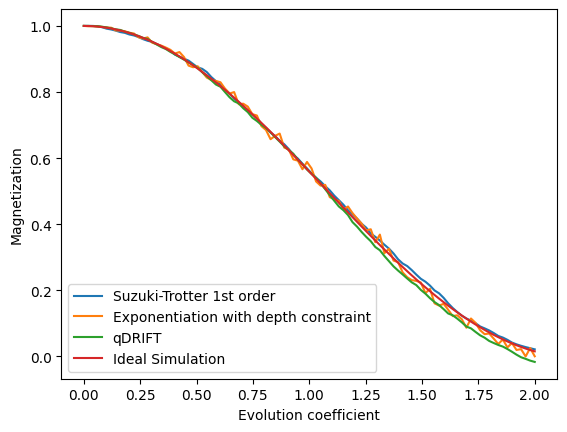

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel("Evolution coefficient")
ax.set_ylabel("Magnetization")
plt.plot(time_list, np.real(magnetization_ST), label="Suzuki-Trotter 1st order")
plt.plot(
    time_list, np.real(magnetization_ewdc), label="Exponentiation with depth constraint"
)
plt.plot(time_list, np.real(magnetization_qdrift), label="qDRIFT")
plt.plot(time_list, np.real(ideal_magnetization), label="Ideal Simulation")
plt.legend()
plt.show()

It's possible to observe that the larger `t` is, the worse the approximation gets for the same set of arguments. To get a better approximation, there is a need for a deeper quantum program with more layers and or with a higher order of approximation.

# Summary and Exercises

This guide introduced the Suzuki-Trotter and qDRIFT methods for Hamiltonian simulation, highlighting the simplicity of Classiq's high level functional design in tackling complex problems.

To become more familiar with the methods and see how the synthesis engine is able to optimize quantum models for Hamiltonian simulation, try to apply the ``qDrift`` and ``Suzuki-Trotter`` methods  to this tutorial as well as different values of the ``evolution_coefficient``:

* [Hamiltonian Evolution for a Water Molecule](https://docs.classiq.io/latest/explore/tutorials/technology_demonstrations/hamiltonian_evolution/hamiltonian_evolution/)

Another good exercise is solving molecules other than the water molecule. With Classiq, you can generate the Hamiltonian of any valid molecule structure, following the same process for the water molecule.

# Read More

Besides the methods presented in this guide, there are also mixed approaches. One of them, proposed by Matthew Hagan and Nathan Wiebe [[6]](#quantum_sim_paper), offers an interesting combination of the Suzuki-Trotter and qDRIFT methods.

# References

<a id='ts_paper'>[1]</a>: [Finding exponential product formulas of higher orders (Naomichi Hatano and Masuo Suzuki)](https://arxiv.org/abs/math-ph/0506007)

<a id='qdrift_paper'>[2]</a>: [A random compiler for fast Hamiltonian simulation (Earl Campbell)](https://arxiv.org/abs/1811.08017)

<a id='qubitization_paper'>[3]</a>: [Hamiltonian simulation by qubitization (Guang Hao Low and Isaac L. Chuang)](https://arxiv.org/abs/1610.06546)

<a id='qsvt_paper'>[4]</a>: [Quantum singular value transformation and beyond: Exponential improvements for quantum matrix arithmetics (András Gilyén, Yuan Su, Guang Hao Low, and Nathan Wiebe)](https://arxiv.org/abs/1806.01838)

<a id='magnetization_paper'>[5]</a>: [The microscopic magnetization: Concept and application (L. L. Hirst)](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.69.607)

<a id='quantum_sim_paper'>[6]</a>: [Composite quantum simulations (Matthew Hagan and Nathan Wiebe)](https://quantum-journal.org/papers/q-2023-11-14-1181/)